In [1]:
import pandas as pd
import numpy as np
import cv2

take frame for the video for which youre testing the model

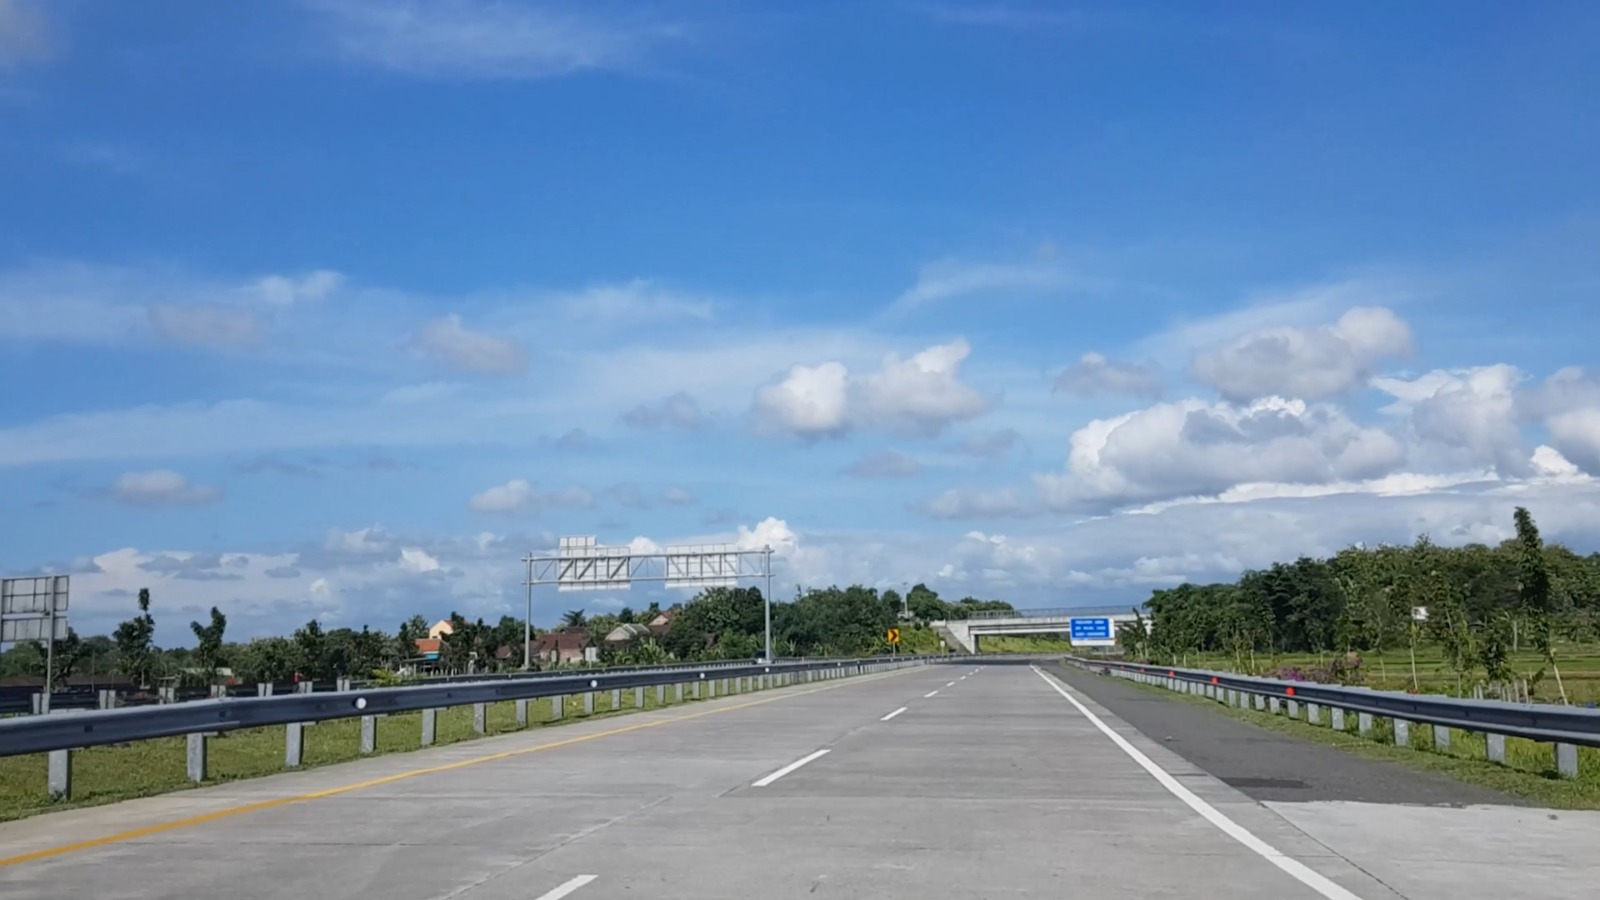

In [2]:
from google.colab.patches import cv2_imshow;
image=cv2.imread("testlaneimage.jpeg")
cv2_imshow(image)

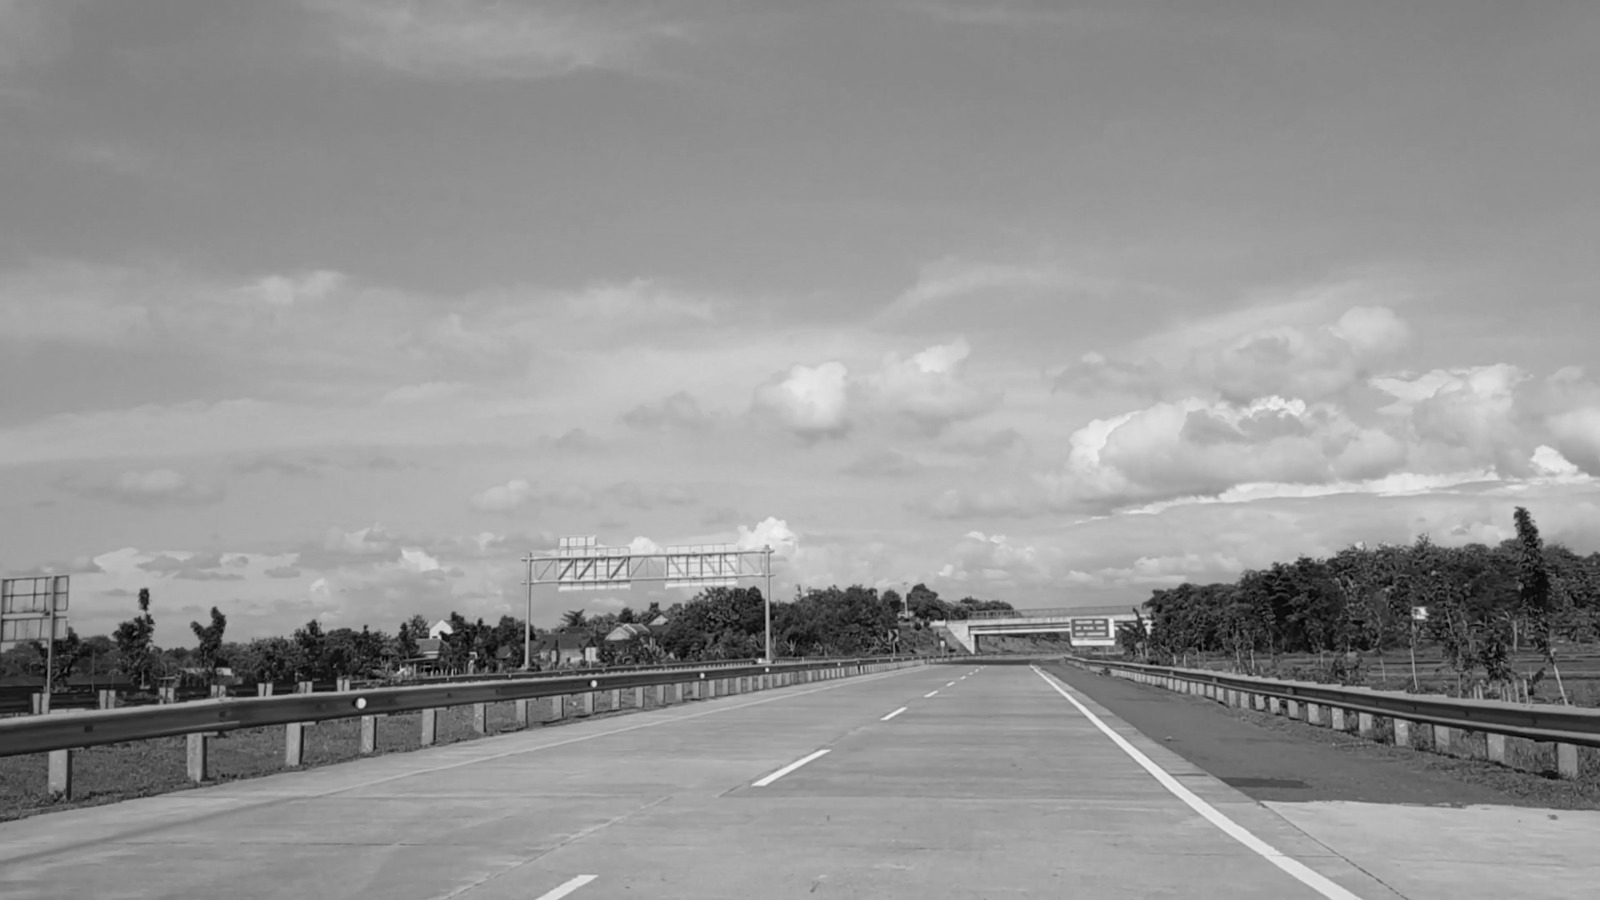

In [3]:
#Converting the image to grayscale
gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
cv2_imshow(gray)

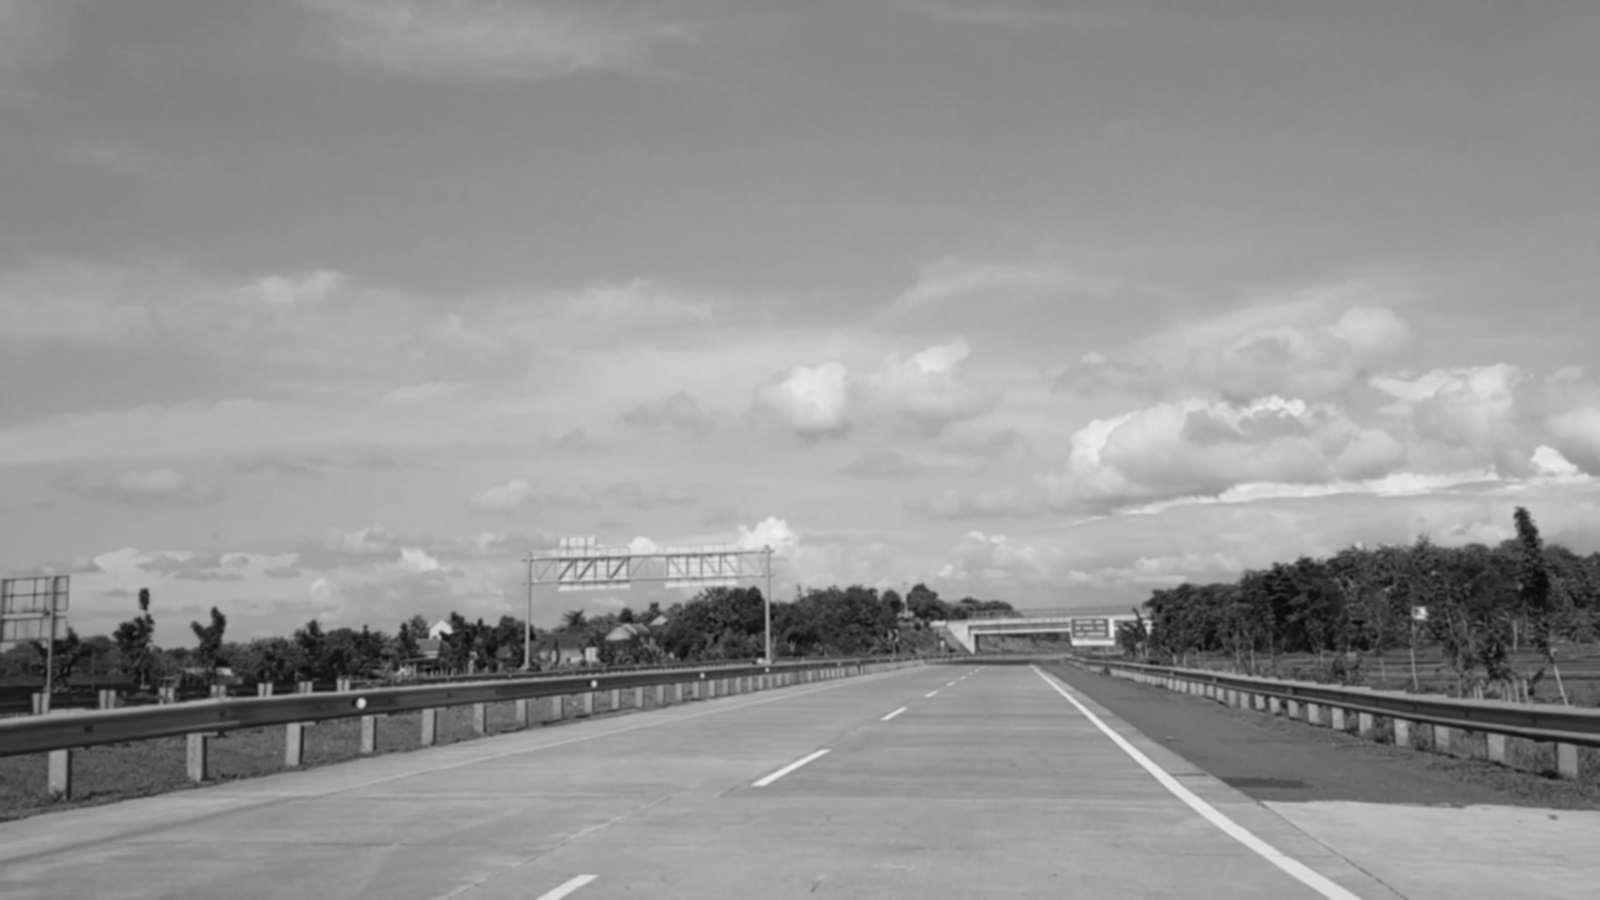

In [4]:
#Blurring the Image
blur=cv2.GaussianBlur(gray,(5,5),0)
cv2_imshow(blur)

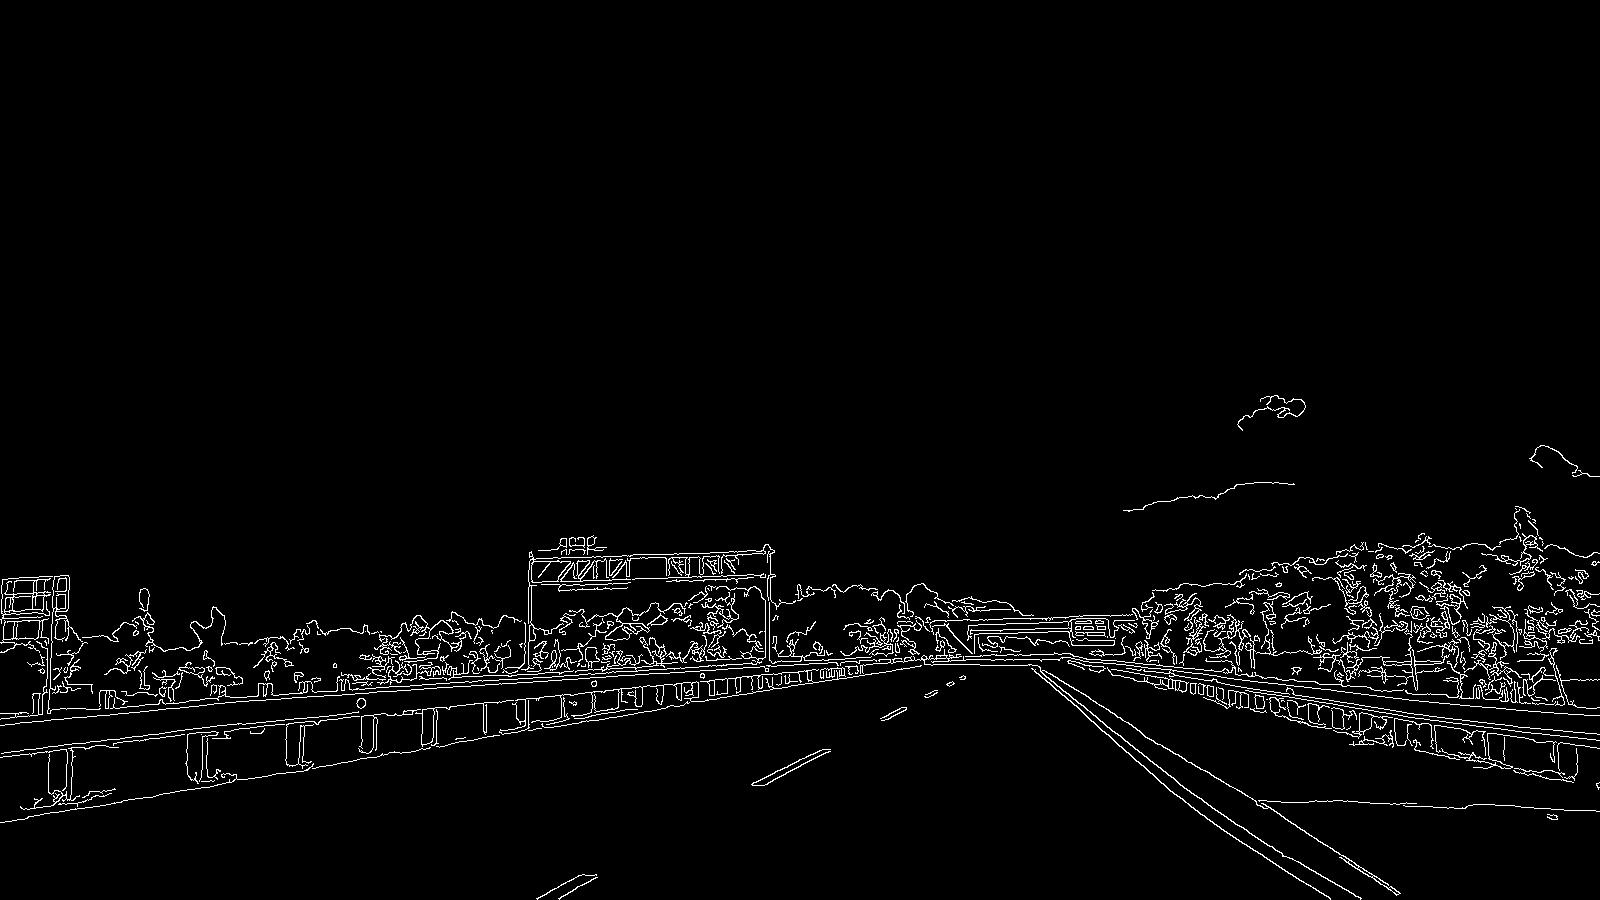

In [5]:
#Highlighting all the lines in the image
canny=cv2.Canny(blur,50,150)
cv2_imshow(canny)

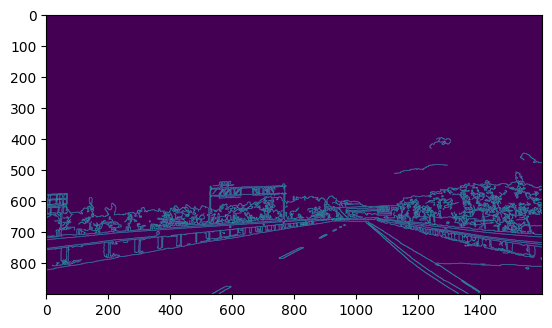

In [6]:
#Visualizing the image to notedown all the axis/coordinates
import matplotlib.pyplot as plt
plt.imshow(canny)
plt.show()

In [7]:
def region_of_interest(image):
  height=image.shape[0]  # Get the height of the image
  polygons=np.array([  # Define a polygonal region of interest
      [(200,height), (1500,height),(1000,700)]  # Define vertices of the polygon
      ])  # left bottom point(x), right bottom point (x),mid point x and hieght point y
  mask= np.zeros_like(image)  # Create a mask of zeros with the same shape as the input image
  cv2.fillPoly(mask, polygons, 255)  # Fill the polygon defined by 'polygons' with white color (255) on the mask
  masked_image=cv2.bitwise_and(image, mask)  # Perform bitwise AND operation between the input image and the mask
  return masked_image  # Return the masked image


In [8]:
def display_lines(image, lines):
  line_image=np.zeros_like(image)  # Create a black image with the same shape as the input image
  if lines is not None:  # Check if the 'lines' array is not empty
    for line in lines:  # Iterate through each line in the 'lines' array
      x1, y1, x2, y2 = line.reshape(4)  # Reshape each line into a 1D array
      cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)  # Draw a line on the 'line_image' with blue color and thickness of 10
  return line_image  # Return the image with drawn lines

In [9]:
def average_slope_intercept(image, lines):
    left_fit = []  # Array to store parameters of left side lines
    right_fit = []  # Array to store parameters of right side lines

    # Loop through each line
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)  # Reshape line into a 1D array
        parameters = np.polyfit((x1, x2), (y1, y2), 1)  # Fit a 1st degree polynomial to x and y coordinates
        slope = parameters[0]  # Get the slope
        intercept = parameters[1]  # Get the y-intercept

        # Determine which side the line is on: right (positive slope) or left (negative slope)
        if slope < 0:
            left_fit.append((slope, intercept))  # Store parameters of left lines
        else:
            right_fit.append((slope, intercept))  # Store parameters of right lines

    # Check if left_fit and right_fit are not empty
    if left_fit:
        left_fit_average = np.average(left_fit, axis=0)  # Compute the average of left line parameters
        left_line = make_coordinates(image, left_fit_average)  # Generate left line coordinates
    else:
        left_line = None

    if right_fit:
        right_fit_average = np.average(right_fit, axis=0)  # Compute the average of right line parameters
        right_line = make_coordinates(image, right_fit_average)  # Generate right line coordinates
    else:
        right_line = None

    # Construct the output array only if both left_line and right_line are not None
    if left_line is not None and right_line is not None:
        return np.array((left_line, right_line))
    elif left_line is not None:
        return np.array((left_line,))
    elif right_line is not None:
        return np.array((right_line,))
    else:
        return np.array(())  # Return an empty array if no lines are detected


In [10]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters  # Extract slope and intercept from line parameters
    y1 = image.shape[0]  # Set y1 to the bottom of the image
    y2 = int(y1 * (3 / 5))  # Set y2 to a point higher up the image (3/5 of the total height)
    x1 = int((y1 - intercept) / slope)  # Calculate x1 using y = mx + c
    x2 = int((y2 - intercept) / slope)  # Calculate x2 using y = mx + c
    return np.array([x1, y1, x2, y2])  # Return coordinates of the line as a numpy array


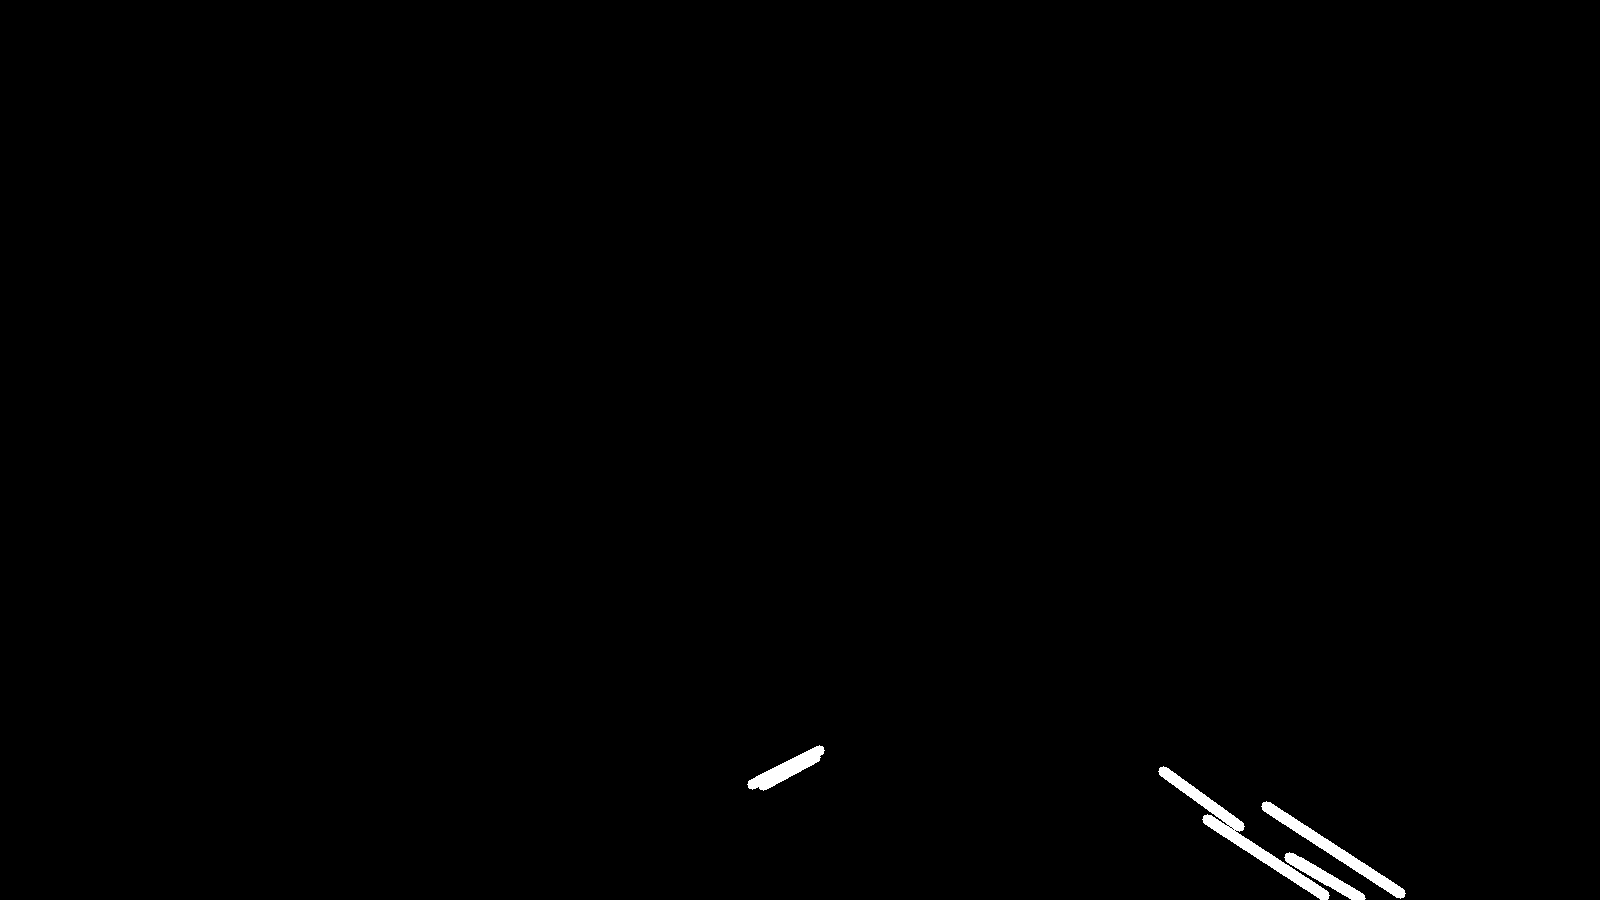

In [11]:
cropped_image = region_of_interest(canny)  # Get the region of interest from the canny edge-detected image
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=2)  # Apply Hough transform to detect lines
lane_image = np.copy(image)  # Create a copy of the original image
line_image = display_lines(lane_image, lines)  # Draw lines on the lane image
n = display_lines(canny, lines)  # Draw lines on the canny edge-detected image
cv2_imshow(n)  # Display the result


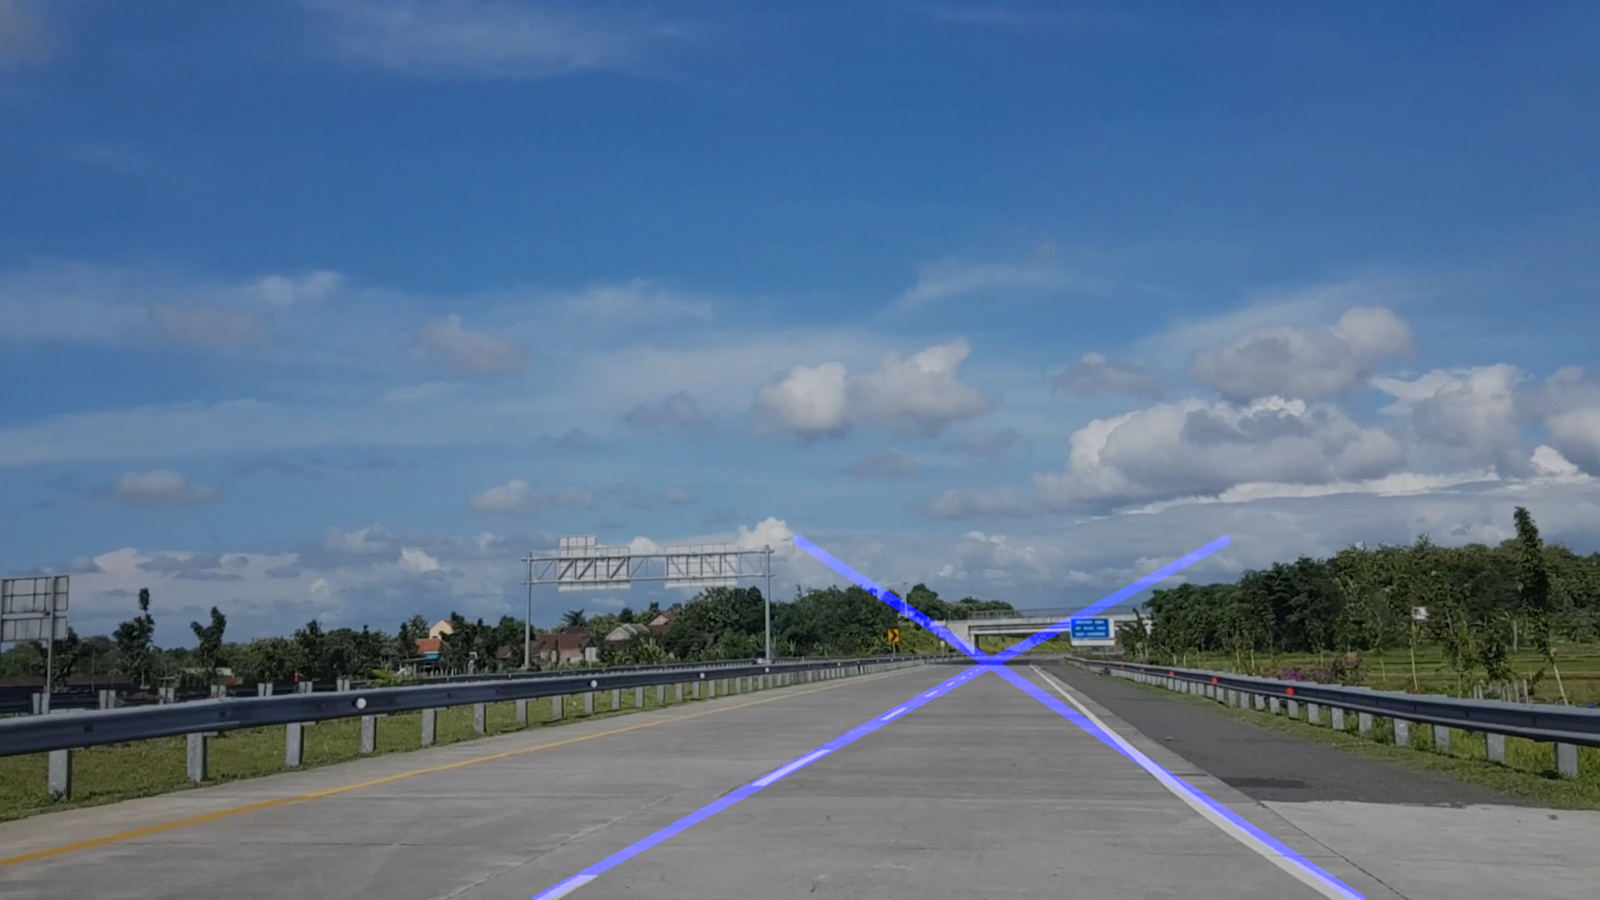

In [12]:
averaged_lines = average_slope_intercept(lane_image, lines)  # Get averaged lines using slope and intercept
line_image = display_lines(lane_image, averaged_lines)  # Draw averaged lines on the lane image

# Blending the outlined black image with the original image
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)  # Blending the lane image and the line image
cv2_imshow(combo_image)  # Display the blended image


In [13]:
print(lines.shape)

(7, 1, 4)


In [14]:
cap = cv2.VideoCapture("testlanevideo1.mp4")  # Open the video file
# Inside the while loop where you process each frame of the video
while (cap.isOpened()):
    _, frame = cap.read()  # Read each frame from the video
    canny_image = cv2.Canny(frame, 50, 150)  # Apply Canny edge detection to the frame
    cropped_image = region_of_interest(canny_image)  # Get the region of interest from the canny edge-detected image
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)  # Detect lines in the cropped image
    line_image = display_lines(frame, averaged_lines)  # Draw averaged lines on the frame
    # Resize line_image to match the dimensions of frame
    line_image_resized = cv2.resize(line_image, (frame.shape[1], frame.shape[0]))
    combo_image = cv2.addWeighted(frame, 0.8, line_image_resized, 1, 1)  # Blend the original frame with the line image
    cv2_imshow(combo_image)  # Display the resulting image
    cv2.waitKey(1)  # Wait for a key press (1 millisecond)
